In [1]:
# IMPORTS 
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from pandas.tseries.offsets import DateOffset
import warnings
warnings.filterwarnings('ignore')
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta
from pandas import Timestamp
from dateutil.rrule import rrule, MONTHLY
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import calendar
from datetime import datetime
import networkx as nx
import math
from pathlib import Path  


# Data Loading and Cleaning 

In [2]:
data_equal = pd.read_csv('49_Industry_Portfolios_Equal.csv')
data_sizes = pd.read_csv('49_Industry_Portfolios_Size.csv')
data = pd.read_csv('ffm.csv')

In [3]:
def clean_empty_industries(data):
    data['Soda '] = data['Soda '].replace(-99.99, np.nan)
    data['Hlth '] = data['Hlth '].replace(-99.99, np.nan)
    data['Rubbr'] = data['Rubbr'].replace(-99.99, np.nan)
    data['FabPr'] = data['FabPr'].replace(-99.99, np.nan)
    data['Guns '] = data['Guns '].replace(-99.99, np.nan)
    data['Gold '] = data['Gold '].replace(-99.99, np.nan)
    data['PerSv'] = data['PerSv'].replace(-99.99, np.nan)
    data['Softw'] = data['Softw'].replace(-99.99, np.nan)
    data['Paper'] = data['Paper'].replace(-99.99, np.nan)
    
    data = data.dropna()
    data = data.reset_index().drop('index', axis=1)
    return data 

In [4]:
data_equal = clean_empty_industries(data_equal)

In [5]:
# CLEAN FARMA AND FRENCH DATA 
new_dates_equal = []
for item in data_equal.values:
    year = str(item[0])[:4]
    month = str(int(item[0]))[4:6]
    new_dates_equal.append(year + "-" + month )
    
new_dates = []
for item in data.values:
    year = str(item[0])[:4]
    month = str(item[0])[4:6]
    new_dates.append(year + "-" + month )

new_dates_size = []
for item in data_sizes.values:
    year = str(item[0])[:4]
    month = str(item[0])[4:6]
    new_dates_size.append(year + "-" + month )

for index in range(len(data_equal['Date'])):
    data_equal['Date'][index] = new_dates_equal[index]

for index in range(len(data['Date'])):
    data['Date'][index] = new_dates[index]
    
for index in range(len(data_sizes['Date'])):
    data_sizes['Date'][index] = new_dates_size[index]

data_equal.Date = pd.to_datetime(data_equal.Date)
data.Date = pd.to_datetime(data.Date)
data_sizes.Date = pd.to_datetime(data_sizes.Date)

for index in range(len(data_equal['Date'])):
    data_equal['Date'][index] = data_equal['Date'][index] + relativedelta(day=31)

for index in range(len(data['Date'])):
    data['Date'][index] = data['Date'][index] + relativedelta(day=31)
    
for index in range(len(data_sizes['Date'])):
    data_sizes['Date'][index] = data_sizes['Date'][index] + relativedelta(day=31)

In [6]:
for column in data_equal.columns:
    new_col = column.rstrip()
    data_equal = data_equal.rename(columns={column: new_col})

In [7]:
for column in data_sizes.columns:
    if column == 'Date':
        continue
    new_col = column.rstrip() + "_SZE"
    data_sizes = data_sizes.rename(columns={column: new_col})
    
equal_sizes = pd.merge(data_equal, data_sizes, how='inner', on=['Date'])

In [8]:
## Reconstruct the data table to have columns of data AND industry to make rolling graphs easier to construct

equal = pd.DataFrame(columns=['Date', 'Industry', 'Return', 'Coeff'])
columns = (list(data_equal.columns))[1:]

for index in range(len(equal_sizes)):
    curr_date = equal_sizes.loc[index, 'Date']
    for curr_industry in columns:
        curr_return = equal_sizes.loc[index, curr_industry]
        curr_size = equal_sizes.loc[index, curr_industry + "_SZE"]
        curr_entry = {'Date': curr_date, 'Industry': curr_industry, 'Return': curr_return, 'SZE': curr_size,'Coeff': 0}
        equal = equal.append(curr_entry, ignore_index=True)



In [9]:
filepath = Path('industry_equal_data.csv')  
data_equal.to_csv(filepath) 

# Construct Graphs and Coefficents 

In [10]:
def add_correlation_edges(graph, sectors, theta, data):
    # data here is previous 12 months 
    for i in sectors:
        for j in sectors:
            curr_corr = data[i].corr(data[j])
            if i != j and abs(curr_corr) > theta:
                graph.add_edge(i, j)
    return graph
            

In [11]:
# .6, .65 alphas -> 0.7588600246863374, 0.6819597720678514
def create_graph(data, sectors): 
    g = nx.Graph()
    g.add_nodes_from(sectors)
    g = add_correlation_edges(g , list(g.nodes), .55, data)
    return g

In [12]:
def solve_optimization_problem():
    return 1/3 

In [13]:
def find_average_centralities(graph):
    average_centrailites = dict()
    scale_factor = solve_optimization_problem()
    
    degree_centrality = nx.degree_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    for node in graph.nodes():
        average_centrailites[node] = 1/3 * (degree_centrality[node]) + 1/3 *(closeness_centrality[node]) + 1/3 *(betweenness_centrality[node])       
    return average_centrailites

In [14]:
def find_monthly_graph(graph_data, data, start_date, end_date, max_date):
    ## for each date, find previous 11 months and find the graph (using data_equal) 
    columns = (list(data.columns))[1:]
    while end_date <= max_date:
        # find graph for that data 
        curr_data = data[(data['Date'] >= start_date) & (data['Date'] <= end_date)]
        curr_graph = create_graph(curr_data, columns)
        
        # find coefficents and add into the table
        average_centralities = find_average_centralities(curr_graph)
        
        for key in average_centralities.keys():
            equal.loc[(equal['Date'] == end_date) & (equal['Industry'] == key), 'Coeff'] = average_centralities[key]            
        
        # update date 
        start_date = start_date + pd.DateOffset(months=1) + pd.offsets.MonthEnd(0)
        end_date = end_date + pd.DateOffset(months=1) + pd.offsets.MonthEnd(0)       
    

In [15]:
find_monthly_graph(equal, data_equal, data_equal.head(1)['Date'].item() - pd.DateOffset(months=11) + pd.offsets.MonthEnd(0), data_equal.head(1)['Date'].item(), data_equal.tail(1)['Date'].item())

## NOTE, THE 1 MONTH SHOULD BE ZERO SO REMOVE IT AND THE SECOND MONHTH IS ALL THE SAME SO DROP IT AS WELL 

equal = equal[equal['Date'] != '1969-07-31']
equal = equal[equal['Date'] != '1969-08-31']




In [16]:
equal

,Date,Industry,Return,Coeff,SZE
98,1969-09-30,Agric,-1.04,0.652961,5.0
99,1969-09-30,Food,-1.53,0.666743,65.0
100,1969-09-30,Soda,-2.66,0.666743,14.0
101,1969-09-30,Beer,-4.51,0.652961,15.0
102,1969-09-30,Smoke,-0.49,0.639465,11.0
...,...,...,...,...,...
31600,2023-03-31,Banks,-16.41,0.613636,388.0
31601,2023-03-31,Insur,-5.75,0.626669,98.0
31602,2023-03-31,RlEst,-2.82,0.641873,32.0
31603,2023-03-31,Fin,-5.16,0.640016,89.0


In [17]:
## write the data csv 
filepath = Path('industry_equal.csv')  
equal.to_csv(filepath) 

In [18]:
ls

30_Industry_Portfolios_Daily.csv
30_Industry_Portfolios_Value.xlsx
49_Industry_Portfolios.CSV
49_Industry_Portfolios_CSV.zip
49_Industry_Portfolios_Equal.csv
49_Industry_Portfolios_Size.csv
49_Industry_Portfolios_Size.xlsx
Betting Against Beta.ipynb
CS-145/
CS_145_Final_Report.pdf
F-F_Research_Data_5_Factors_2x3.csv
F-F_Research_Data_5_Factors_2x3_CSV.zip
IMGC0002.jpg
IMGC0030.jpg
IMGC0031.jpg
Industry Portfolios Yearly Rebalancing.ipynb
Papers/
ffm.csv
ffm.numbers*
industry_equal.csv
industry_equal_data.csv
monthly_stock copy.csv
monthly_stock.csv


# Construct Portfolio Now 
--------------------------------------
Note, we will find the new portfolio at every month. We sort into quartiles and short the top while longing the bottom. 

In [19]:
## need to find quartlies and seperate into short/long 
def find_deciles(group):
    group['Decile'] = pd.qcut(group['SZE'].rank(method='first'), 10, labels=False)
    return group

In [20]:
equal = equal.groupby('Date').apply(find_deciles)
equal_short = equal[equal['Decile'] == 9]
equal_long = equal[equal['Decile'] == 0]

In [21]:
def find_weights(group):
    total_size = group['SZE'].sum()
    num_stocks = group['SZE'].count()
    group['EQ_weight'] = 1/float(num_stocks)
    group['VAL_weight'] = group['SZE']/total_size
    return group

In [22]:
equal_short = equal_short.groupby('Date').apply(find_weights)
equal_short['EQ'] = equal_short['Return'] * equal_short['EQ_weight']
equal_short['VAL'] = equal_short['Return'] * equal_short['VAL_weight']
equal_short = equal_short.reset_index()
equal_short = equal_short.drop('index', axis=1)


equal_long = equal_long.groupby('Date').apply(find_weights)
equal_long['EQ'] = equal_long['Return'] * equal_long['EQ_weight']
equal_long['VAL'] = equal_long['Return'] * equal_long['VAL_weight']
equal_long = equal_long.reset_index()
equal_long = equal_long.drop('index', axis=1)

In [23]:
# for each date, find the overall short and long portfolio which is just a sum 
new_data = pd.DataFrame(columns=['Date', 'EQ', 'VAL'])
new_data['Date'] = equal_long['Date'].unique()

In [24]:
eq_grouped_long = equal_long.groupby('Date')['EQ'].sum().reset_index()
eq_grouped_short = equal_short.groupby('Date')['EQ'].sum().reset_index()
new_data['EQ'] = eq_grouped_long['EQ'] - eq_grouped_short['EQ']

val_grouped_long = equal_long.groupby('Date')['VAL'].sum().reset_index()
val_grouped_short = equal_short.groupby('Date')['VAL'].sum().reset_index()
new_data['VAL'] = val_grouped_long['VAL'] - val_grouped_short['VAL']

In [25]:
filepath = Path('ffm_industry.csv')  
data.to_csv(filepath) 

In [26]:
data = data.rename(columns={'Mkt-RF': 'Mkt_RF'})
data['Mkt'] = data.Mkt_RF + data.RF

In [27]:
merged_data = pd.merge(new_data, data, how='inner', on=['Date'])
merged_data['EQ_RF'] = merged_data['EQ'] - merged_data['RF']
merged_data['VAL_RF'] = merged_data['VAL'] - merged_data['RF']

In [28]:
merged_data

,Date,EQ,VAL,Mkt_RF,SMB,HML,RMW,CMA,RF,Mkt,EQ_RF,VAL_RF
0,1969-09-30,-0.936,-0.303257,-2.98,1.29,-3.27,3.39,-0.82,0.62,-2.36,-1.556,-0.923257
1,1969-10-31,7.066,1.321464,5.06,3.96,-3.16,0.05,-2.15,0.60,5.66,6.466,0.721464
2,1969-11-30,-0.644,0.798799,-3.79,-2.45,-1.19,1.46,0.30,0.52,-3.27,-1.164,0.278799
3,1969-12-31,0.078,0.110774,-2.63,-3.76,-2.86,2.54,-1.81,0.64,-1.99,-0.562,-0.529226
4,1970-01-31,-4.386,-0.312874,-8.10,3.12,3.13,-1.72,3.84,0.60,-7.50,-4.986,-0.912874
...,...,...,...,...,...,...,...,...,...,...,...,...
638,2022-11-30,6.008,5.855097,4.60,-2.67,1.38,6.01,3.11,0.29,4.89,5.718,5.565097
639,2022-12-31,-0.162,-1.271185,-6.41,-0.16,1.32,0.09,4.19,0.33,-6.08,-0.492,-1.601185
640,2023-01-31,1.444,3.022602,6.65,4.43,-4.05,-2.62,-4.53,0.35,7.00,1.094,2.672602
641,2023-02-28,3.820,3.525853,-2.58,0.69,-0.78,0.90,-1.41,0.34,-2.24,3.480,3.185853


# Portfolio Analysis

In [29]:
def find_corr(r1, r2):
    return r1.corr(r2)

In [30]:
def compute_monthly_average(ret_col):
    return np.mean(ret_col)

def compute_monthly_volatility(data_lst):
    return np.std(data_lst)

def compute_monthly_sharpe_ratio(portfolio_return, rf):
    return ((np.mean(portfolio_return) - np.mean(rf))/np.std(portfolio_return))

In [31]:
def find_quantative_measures(weight_type, data):
    print("MEAN MONTHLY RETURNS")
    print(f"FF Equal Portfolio {weight_type}: {compute_monthly_average(data[weight_type])}")
    print(f"FF Market Portfolio: {compute_monthly_average(data['Mkt'])}")
    print()
    
    print("MONTHLY VOLATILITY")
    print(f"FF Equal Portfolio {weight_type}: {compute_monthly_volatility(data[weight_type])}")
    print()
    
    print("MONTHLY SHARPE RATIO")
    print(f"FF Equal Portfolio {weight_type}: {compute_monthly_sharpe_ratio(data[weight_type], data['RF'])}")
    print()

In [32]:
def capm(data, lower_date, higher_date, formula, weight_type):
    print(f"FF EQUAL PORTFOLIO {weight_type}")
    if not higher_date:
        model = smf.ols(formula=formula, data=data[data['Date'] > lower_date]).fit()
    else:
        model = smf.ols(formula=formula, data=data[(data['Date'] > lower_date) & (data['Date'] < higher_date)]).fit()
    print(f"P Value: {model.pvalues[0]}")
    print(f"Beta of the {weight_type} Stratgey: {model.params[1]}")
    print(f"Alpha of the {weight_type} Stratgey: {model.params[0]}")    
    beta = model.params[1]
    return beta

## EQUAL PORTFOLIO EQUAL WEIGHTED

In [33]:
eq_market_corr = find_corr(merged_data[(merged_data['Date'] > '1999-12-31')]['EQ'], merged_data[merged_data['Date'] > '1999-12-31']['Mkt'])
print(f"Correlation of EQ Portflio with the Market: {eq_market_corr}")
print()
find_quantative_measures('EQ', merged_data[merged_data['Date'] > '1999-12-31'])

Correlation of EQ Portflio with the Market: -0.3066965053424606

MEAN MONTHLY RETURNS
FF Equal Portfolio EQ: 0.7030035842293906
FF Market Portfolio: 0.6469175627240144

MONTHLY VOLATILITY
FF Equal Portfolio EQ: 5.275894808678924

MONTHLY SHARPE RATIO
FF Equal Portfolio EQ: 0.1092736208621674



FF EQUAL PORTFOLIO EQ
P Value: 0.7649097119082767
Beta of the EQ Stratgey: -0.1672021676381431
Alpha of the EQ Stratgey: 0.17578085383054962


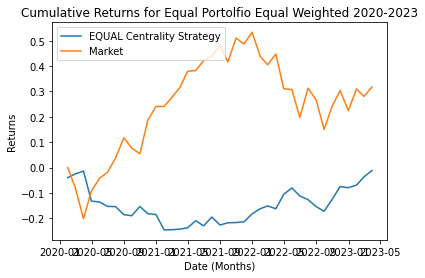

In [34]:
### 2020-2023 RETURNS
date = '2019-12-31'
beta_eq_1980_2023 = capm(merged_data, date, None, 'EQ_RF ~ Mkt_RF', 'EQ')

plt.figure()
plt.plot(merged_data[merged_data['Date'] > date]['Date'], (1 + merged_data[merged_data['Date'] > date]['EQ_RF']/100).cumprod() - 1)
plt.plot(merged_data[merged_data['Date'] > date]['Date'], (1 + merged_data[merged_data['Date'] > date]['Mkt']/100).cumprod() - 1)

plt.xlabel("Date (Months)")
plt.ylabel("Returns")
plt.title(f"Cumulative Returns for Equal Portolfio Equal Weighted 2020-2023")
plt.legend(['EQUAL Centrality Strategy', 'Market', 'Implied Returns'])
plt.show() 

FF EQUAL PORTFOLIO EQ
P Value: 0.011649875053126266
Beta of the EQ Stratgey: -0.40800722480777973
Alpha of the EQ Stratgey: 0.8564027419374374


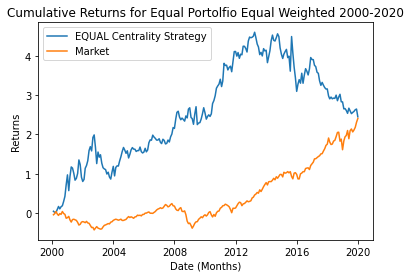

In [35]:
### 2000-2020 RETURNS
lower_date = '1999-12-31'
higher_date = '2020-01-01'
beta_eq_1990_2000 = capm(merged_data, lower_date, higher_date, 'EQ_RF ~ Mkt_RF', 'EQ')

plt.figure()
plt.plot(merged_data[(merged_data['Date'] > lower_date) & (merged_data['Date'] < higher_date)]['Date'], (1 + merged_data[(merged_data['Date'] > lower_date) & (merged_data['Date'] < higher_date)]['EQ_RF']/100).cumprod() - 1)
plt.plot(merged_data[(merged_data['Date'] > lower_date) & (merged_data['Date'] < higher_date)]['Date'], (1 + merged_data[(merged_data['Date'] > lower_date) & (merged_data['Date'] < higher_date)]['Mkt']/100).cumprod() - 1)

plt.xlabel("Date (Months)")
plt.ylabel("Returns")
plt.title(f"Cumulative Returns for Equal Portolfio Equal Weighted 2000-2020")
plt.legend(['EQUAL Centrality Strategy', 'Market', 'Implied Returns'])
plt.show() 

FF EQUAL PORTFOLIO EQ
P Value: 0.012550515427598495
Beta of the EQ Stratgey: -0.3503715350377969
Alpha of the EQ Stratgey: 0.7588600246863374


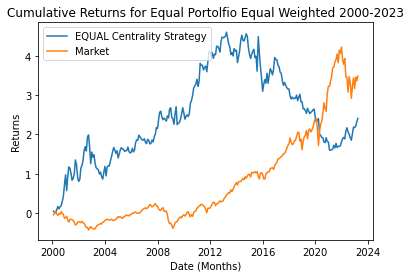

In [36]:
### 2000-2023 RETURNS
date = '1999-12-31'
beta_eq_2000_2023 = capm(merged_data, date, None, 'EQ_RF ~ Mkt_RF', 'EQ')

plt.figure()
plt.plot(merged_data[merged_data['Date'] > date]['Date'], (1 + merged_data[merged_data['Date'] > date]['EQ_RF']/100).cumprod() - 1)
plt.plot(merged_data[merged_data['Date'] > date]['Date'], (1 + merged_data[merged_data['Date'] > date]['Mkt']/100).cumprod() - 1)

plt.xlabel("Date (Months)")
plt.ylabel("Returns")
plt.title(f"Cumulative Returns for Equal Portolfio Equal Weighted 2000-2023")
plt.legend(['EQUAL Centrality Strategy', 'Market', 'Implied Returns'])
plt.show() 

## EQUAL PORTFOLIO VALUE WEIGHTED

In [37]:
val_market_corr = find_corr(merged_data[(merged_data['Date'] > '1999-12-31')]['VAL'], merged_data[merged_data['Date'] > '1999-12-31']['Mkt'])
print(f"Correlation of VAL Portflio with the Market: {val_market_corr}")
print()
find_quantative_measures('VAL', merged_data[merged_data['Date'] > '1999-12-31'])

Correlation of VAL Portflio with the Market: -0.24883346293422529

MEAN MONTHLY RETURNS
FF Equal Portfolio VAL: 0.6711110253383886
FF Market Portfolio: 0.6469175627240144

MONTHLY VOLATILITY
FF Equal Portfolio VAL: 4.909754820473522

MONTHLY SHARPE RATIO
FF Equal Portfolio VAL: 0.1109268364827899



FF EQUAL PORTFOLIO VAL
P Value: 0.5183545977773601
Beta of the VAL Stratgey: -0.04688647715456793
Alpha of the VAL Stratgey: 0.40265630593544866


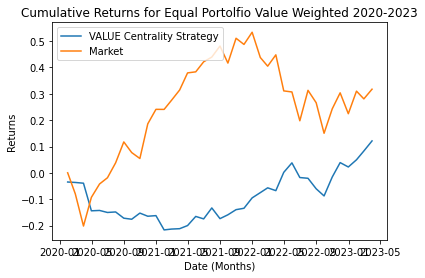

In [38]:
###2020-2023 RETURNS
date = '2019-12-31'
beta_val_1980_2023 = capm(merged_data, date, None, 'VAL_RF ~ Mkt_RF', 'VAL')

plt.figure()
plt.plot(merged_data[merged_data['Date'] > date]['Date'], (1 + merged_data[merged_data['Date'] > date]['VAL_RF']/100).cumprod() - 1)
plt.plot(merged_data[merged_data['Date'] > date]['Date'], (1 + merged_data[merged_data['Date'] > date]['Mkt']/100).cumprod() - 1)

plt.xlabel("Date (Months)")
plt.ylabel("Returns")
plt.title(f"Cumulative Returns for Equal Portolfio Value Weighted 2020-2023")
plt.legend(['VALUE Centrality Strategy', 'Market', 'Implied Returns'])
plt.show() 

FF EQUAL PORTFOLIO VAL
P Value: 0.02132153641379851
Beta of the VAL Stratgey: -0.3334093928398133
Alpha of the VAL Stratgey: 0.7312386931825486


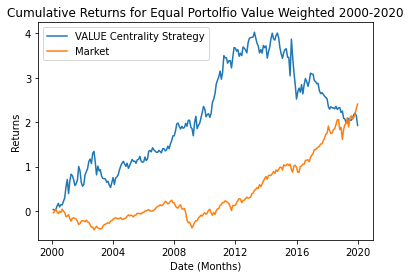

In [39]:
### 2000-2020 RETURNS
lower_date = '1999-12-31'
higher_date = '2020-01-01'
beta_val_1990_2000 = capm(merged_data, lower_date, higher_date, 'VAL_RF ~ Mkt_RF', 'VAL')

plt.figure()
plt.plot(merged_data[(merged_data['Date'] > lower_date) & (merged_data['Date'] < higher_date)]['Date'], (1 + merged_data[(merged_data['Date'] > lower_date) & (merged_data['Date'] < higher_date)]['VAL_RF']/100).cumprod() - 1)
plt.plot(merged_data[(merged_data['Date'] > lower_date) & (merged_data['Date'] < higher_date)]['Date'], (1 + merged_data[(merged_data['Date'] > lower_date) & (merged_data['Date'] < higher_date)]['Mkt']/100).cumprod() - 1)

plt.xlabel("Date (Months)")
plt.ylabel("Returns")
plt.title(f"Cumulative Returns for Equal Portolfio Value Weighted 2000-2020")
plt.legend(['VALUE Centrality Strategy', 'Market', 'Implied Returns'])
plt.show() 

FF EQUAL PORTFOLIO VAL
P Value: 0.01785360280306806
Beta of the VAL Stratgey: -0.26388980948705393
Alpha of the VAL Stratgey: 0.6819597720678514


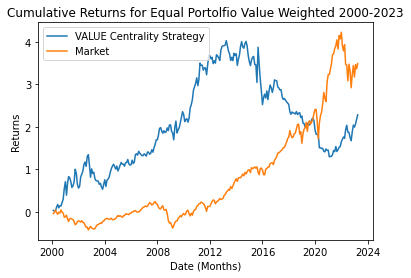

In [40]:
### 2000-2023 RETURNS
date = '1999-12-31'
beta_eq_2000_2023 = capm(merged_data, date, None, 'VAL_RF ~ Mkt_RF', 'VAL')

plt.figure()
plt.plot(merged_data[merged_data['Date'] > date]['Date'], (1 + merged_data[merged_data['Date'] > date]['VAL_RF']/100).cumprod() - 1)
plt.plot(merged_data[merged_data['Date'] > date]['Date'], (1 + merged_data[merged_data['Date'] > date]['Mkt']/100).cumprod() - 1)

plt.xlabel("Date (Months)")
plt.ylabel("Returns")
plt.title(f"Cumulative Returns for Equal Portolfio Value Weighted 2000-2023")
plt.legend(['VALUE Centrality Strategy', 'Market', 'Implied Returns'])
plt.show() 

In [41]:
## at each month (so each data entry), create a graph and find the coefficents 
## note the graph will be rolling, for a time interval of 1 year (12 months)
## so, pass in month + 111 at a time for correlation graph, but using rolling coefficents for portfolio
## construction 

## if 11 previous months are not available, we use however many are available

## so the first month, is dropped since all centrality coefficents are zero since there are no correlations yet due 
## to only one month of returns 

## NOTE, PREVIOUS 11 MONTHS ARE NEEDED. 


## 

